Options:

1. Mimize portfolio variance / maximum expected return minus portfolio variance
2. Sum of weights = 1 / Sum of weights = 0 / sum of weights is unconstrained
3. There is no risk-free asset / there IS a risk-free asset
4. No transaction costs / quadratic transaction costs / linear transaction costs

In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## TOC
1. [Introduction into investor's preferences](###Introduction)
2. [Unconstrained optimization](###Unconstrained-optimization)
3. [Global minimum variance portfolio](###Global-minimum-variance-portfolio)
4. [Optimization when the sum of weights is equal to 1](###Optimization-when-sum-of-weights-is-equal-to-1)
5. [Optimization with transaction costs](###Optimization-with-transaction-costs)
6. [Optimization with risk-free asset](###Optimization-with-risk-free-asset) TODO

### Introduction

Well, okay. You want to invest in some stocks, maybe bonds (or crypto?) but you are stuck at the process of choosing how much of every asset to buy. You can pick some numbers that seem just fine for you, but since you are mathematically rigorous, you want your allocation be based on some optimization. So, how to do that?

First of all, we need to figure our what we want to optimize with respect to asset allocation.
Let us define $w \in R^n$ as a vector of asset weights, i.e. asset allocation. If we observe returns $r$, than the return of our portfolio is $w^{T}r$, isn't it?

Let us denote $r_p = w^{T}r$. We probably think that the more money we get, the happier we are. Hence, we want to maximize this thing! In reality, when making decision about weights, we do not know what returns will be actualized in the future. Hence, we may try to optimize the **expected** return of the portfolio:<br><br>
$E[r_p] = E[w^{T}r] = w^{T}E[r] = w^{T}\mu \to max_{w}$<br><br>
Well, okay, then if there is one asset with the highest expected return, the solution wll be to buy an infite amount of it, right? Does not makes sense and does not align with the reality of portfolio investments.

If we think more about our preferences, we can conclude that we dislike volatility. All else being equal, would you prefer investing in an asset that brings $1 in all states of the world or an asset that brings $1 only on average? In finance and economics, we usually assume that people are risk averse, so they tend to prefer the former. Therefore, when choosing asset allocation, we should penalize its variance:<br><br>
$Var(r_p) = Var(w^{T}r) = w^{T}[Var(r)]w = w^{T} \Sigma w$<br>

Well, nice, let's say that our utility function looks as follows:
$U(w) = E(r_p) - Var(r_p)$<br>

Now you can shout at me: what if I have two investors who have different risk tolerance? This is possible, right? And I would agree with you, thanks for pointing this out, dude. We can formalize this by multiplying the variance of portfolio by $\frac{\gamma}{2} > 0$, where $\gamma$ measures risk aversion. If $\gamma=0$, we do not care about volatility. As it goes to infinity, we care more and more about it.<br>

$U(w) = E(r_p) - \dfrac{\gamma}{2} Var(r_p) = w^{T}\mu - \dfrac{\gamma}{2} w^{T} \Sigma w$<br>

Nice stuff! So let's just optimize it?<br>
 

### Synthetic data
Let us simulate data for expected returns $\mu$ and covariance matrix of returns $\Sigma$ to proceed with optimization examples. Let us also set $\gamma = 2$.

In [4]:
import numpy
numpy.random.seed(2023)

n = 5

mu = numpy.random.uniform(-1, 1, n)
Sigma = numpy.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)
gamma = 2

In [5]:
pandas.Series(mu)

0   -0.356023
1    0.780845
2    0.176105
3   -0.746808
4   -0.717318
dtype: float64

In [6]:
pandas.DataFrame(Sigma)

,0,1,2,3,4
0,4.927933,-4.280763,0.749537,-0.283806,-1.083995
1,-4.280763,8.447121,1.410513,3.958052,2.277475
2,0.749537,1.410513,1.506218,2.583646,-0.211710
3,-0.283806,3.958052,2.583646,7.464284,-3.300409
4,-1.083995,2.277475,-0.211710,-3.300409,5.480581


### Optimization 101
Before we dig deep into optimization, let us consider two special cases:
a) We care only about volatility and the sum of weights is 1;
b) We care both about expected return and volatility but we do not constrain the sum of weights.

Both are not very realistic but will help but develop some intuition and build a bridge to more realistic setups!

#### Unconstrained optimization

$U(w) = E(r_p) - \dfrac{\gamma}{2} Var(r_p) = w^{T}\mu - \dfrac{\gamma}{2} w^{T} \Sigma w$<br>
FOC: $\dfrac{dU}{dw} = \mu - \gamma \Sigma w = 0$<br><br>
Simple rule of thumb when taking the multidimension derivatives: the dimension of the derivative must be equal to the dimension of the variable w.r.t. which you take the derivate ($w$ here!).

$\gamma \Sigma w = \mu$<br>
$w_{UC} = \dfrac{1}{\gamma} \Sigma^{-1} \mu$

Cool, have we reached the maximum?<br><br>
$\dfrac{d^2U}{dwdw^T} = - \gamma \Sigma$ is negative semi-definite, so yes!

$w_{UC} = \dfrac{1}{\gamma} \Sigma^{-1} \mu$ has a couple of nice (intuitive!) interpretations:
1. When your risk aversion goes to infinity, your portfolio allocation tends to a zero vector (invest in nothing!)
2. Higher expected return $\mu_i$ will have a positive effect on $w_i$
3. The inverse of the covariance matrix scales weights according to asset variances and covariances. In fact, this matrix is called a precision matrix and its elements are conditional covariances! (We can cover that later)

In [7]:
def uncostrained_optimal_allocation(mu: numpy.array, Sigma: numpy.array, gamma: float) -> numpy.array:
    Sigma_inv = numpy.linalg.inv(Sigma)
    return 1/gamma * Sigma_inv @ mu

In [8]:
w_unconstrained = uncostrained_optimal_allocation(
    mu=mu, Sigma=Sigma, gamma=gamma
)
w_unconstrained

array([  1.15593787,   7.48631187,  14.39985368, -13.65286469,
       -10.61328526])

In [9]:
w_experiments = {}
for gamma in numpy.linspace(0.05, 2, 100):
    cur_w = uncostrained_optimal_allocation(
        mu=mu, Sigma=Sigma, gamma=gamma
    )
    w_experiments[gamma] = cur_w

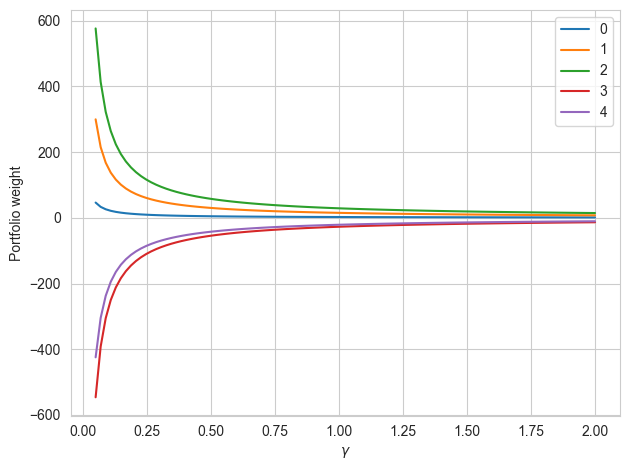

In [10]:
pandas.DataFrame(w_experiments).T.plot()
plt.xlabel(r'$\gamma$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

#### Special case: two assets

$$
\mu = \left(\begin{array}{c} 
\mu_1\\
\mu_2
\end{array}\right)
$$

$$
\Sigma = \left(\begin{array}{cc} 
\sigma^2_1 & \sigma_{12}\\
\sigma_{12} & \sigma^2_2
\end{array}\right)
$$

$$
\Sigma^{-1} = \dfrac{1}{det(\Sigma)} * \left(\begin{array}{cc} 
\sigma^2_2 & -\sigma_{12}\\
-\sigma_{12} & \sigma^2_1
\end{array}\right)
$$
$$det(\Sigma) = \sigma^2_1*\sigma^2_2 -  \sigma_{12}^2$$

$$
\Sigma^{-1}\mu = \dfrac{1}{det(\Sigma)} * \left(\begin{array}{cc} 
\sigma^2_2 & -\sigma_{12}\\
-\sigma_{12} & \sigma^2_1
\end{array}\right) * \left(\begin{array}{c} 
\mu_1\\
\mu_2
\end{array}\right) = \dfrac{1}{det(\Sigma)} * \left(\begin{array}{c} 
\sigma^2_{2}\mu_1 - \sigma_{12}\mu_2\\
\sigma^2_{1}\mu_2 - \sigma_{12}\mu_1 \end{array}\right)
$$

$$
\Sigma^{-1}\mu = \left(\begin{array}{c} 
\dfrac{\sigma^2_{2}\mu_1 - \sigma_{12}\mu_2}{det(\Sigma)}\\
\\
\dfrac{\sigma^2_{1}\mu_2 - \sigma_{12}\mu_1}{det(\Sigma)} \end{array}\right) = \left(\begin{array}{c} 
\dfrac{\mu_1\sigma^2_{2} - \mu_2\sigma_{12}}{\sigma^2_1\sigma^2_2 -  \sigma_{12}^2}\\
\\
\dfrac{\mu_2\sigma^2_{1} - \mu_1\sigma_{12}}{\sigma^2_1\sigma^2_2 -  \sigma_{12}^2} \end{array}\right)
$$

$$
w_{UC} = \dfrac{1}{\gamma} \Sigma^{-1} \mu = \dfrac{1}{\gamma} \left(\begin{array}{c} 
\dfrac{\mu_1\sigma^2_{2} - \mu_2\sigma_{12}}{\sigma^2_1\sigma^2_2 -  \sigma_{12}^2}\\
\\
\dfrac{\mu_2\sigma^2_{1} - \mu_1\sigma_{12}}{\sigma^2_1\sigma^2_2 -  \sigma_{12}^2} \end{array}\right)
$$

Special case: two uncorrelated assets ($\sigma_{12} = 0$):

$$
w_{UC} = \dfrac{1}{\gamma} \Sigma^{-1} \mu = \dfrac{1}{\gamma} \left(\begin{array}{c} 
\dfrac{\mu_1\sigma^2_{2}}{\sigma^2_1\sigma^2_2}\\
\\
\dfrac{\mu_2\sigma^2_{1}}{\sigma^2_1\sigma^2_2} \end{array}\right)
$$

$$
w_{UC} = \dfrac{1}{\gamma} \left(\begin{array}{c} 
\dfrac{\mu_1}{\sigma^2_1}\\
\\
\dfrac{\mu_2}{\sigma^2_2} \end{array}\right)
$$

In [11]:
mu_2dim = mu[:2]
Sigma_2dim = Sigma[:2, :2]
Sigma_2dim = numpy.diag(numpy.diag(Sigma_2dim)) # set cov to 0

In [12]:
w_uc_2dim = uncostrained_optimal_allocation(mu=mu_2dim, Sigma=Sigma_2dim, gamma=gamma)

assert w_uc_2dim[0] - 1/gamma * mu[0] / Sigma[0, 0] < 1e-6
assert w_uc_2dim[1] - 1/gamma * mu[1] / Sigma[1, 1] < 1e-6

w_uc_2dim

array([-0.036123  ,  0.04621959])

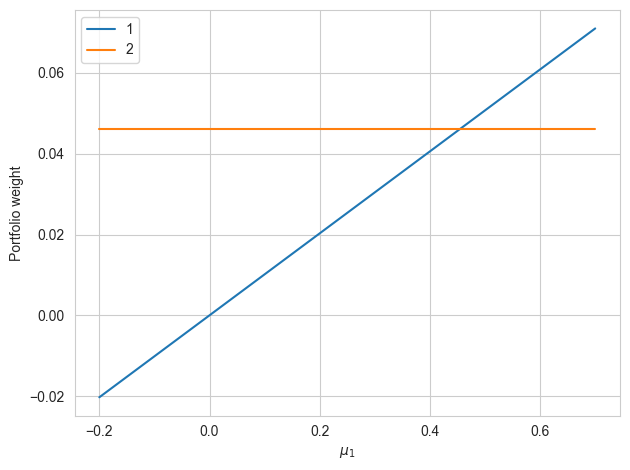

In [13]:
w_uc_exps = {}
for mu1 in numpy.linspace(-0.2, 0.7, 1_000):
    cur_mu = numpy.array([mu1, mu_2dim[1]])
    w_uc_exps[mu1] = uncostrained_optimal_allocation(mu=cur_mu, Sigma=Sigma_2dim, gamma=gamma)

w_uc_exps_df = pandas.DataFrame(w_uc_exps).T
w_uc_exps_df.columns = [1, 2]

w_uc_exps_df.plot()
plt.xlabel('$\mu_1$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

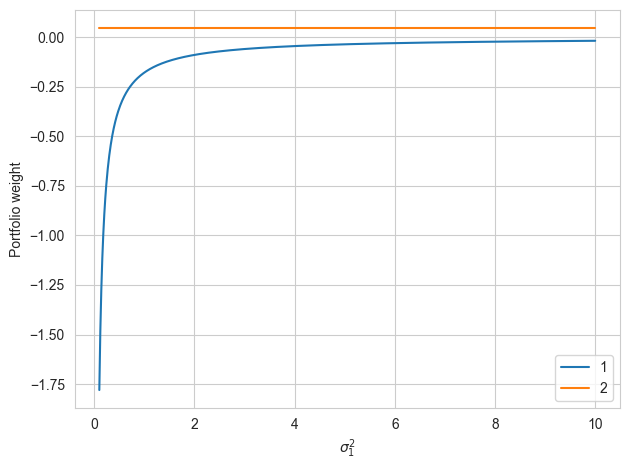

In [14]:
w_uc_exps = {}
for sigma1_squared in numpy.linspace(0.1, 10, 1_000):
    cur_Sigma = Sigma_2dim.copy()
    cur_Sigma[0, 0] = sigma1_squared
    w_uc_exps[sigma1_squared] = uncostrained_optimal_allocation(mu=mu_2dim, Sigma=cur_Sigma, gamma=gamma)

w_uc_exps_df = pandas.DataFrame(w_uc_exps).T
w_uc_exps_df.columns = [1, 2]

w_uc_exps_df.plot()
plt.xlabel('$\sigma_{1}^{2}$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

### Scaled unconstrained optimum
After receiving the optimal allocation, we can request the sum of weights to be equal to 1 (the sum is bounded). What do we get then?

$w_B = \dfrac{1}{{w^{T}_{UC}} \tau}{w_{UC}} = \dfrac{1}{\frac{1}{\gamma}\mu^T\Sigma^{-1}\tau} * \dfrac{1}{\gamma}\Sigma^{-1}\mu = \dfrac{1}{\mu^T\Sigma^{-1}\tau} \Sigma^{-1}\mu$<br>

The solution does not depend on $\gamma$ anymore! Indeed, the risk aversion acts as a weight scaler. If we fix the sum of weights at a 1, we essentiall choose $\gamma$ to be $\mu^T\Sigma^{-1}\tau$ in advance.<br>
Also, let us denote $B = \mu^T\Sigma^{-1}\tau$.

In [13]:
def scaled_optimum(mu: numpy.array, Sigma: numpy.array) -> numpy.array:
    unit = numpy.ones_like(mu)
    Sigma_inv = numpy.linalg.inv(Sigma)

    implied_gamma = mu.T @ Sigma_inv @ unit
    
    return 1 / implied_gamma * Sigma_inv @ mu

#### Global minimum variance portfolio

Before we proceed with more sophisticated versions of mean-variance optimization, let us assume for a moment that
1. I want to the sum of weights to be 1
2. But I care only about the portfolio volatility, please minimize it!

Ok, sure:

\begin{cases}
\begin{align*}
U(w) = w^{T} \Sigma w \to min_{w} \\
w^{T}\tau = 1, \text{where } \tau \text{ is a vector of ones} \\
\end{align*}
\end{cases}

$\Lambda = w^{T}\Sigma w - \lambda(w^{T}\tau - 1) \to \min_{w, \lambda}$

FOC:
\begin{cases}
\begin{align*}
\frac{d\Lambda}{dw} = \Sigma w - \lambda \tau = 0 \\
\frac{d\Lambda}{d\lambda} = w^{T} \tau - 1 = 0 \\
\end{align*}
\end{cases}

$\Sigma w = \lambda \tau$<br>
$w = \lambda \Sigma^{-1} \tau$<br>

$[ \lambda \Sigma^{-1} \tau]^{T} \tau - 1 = 0$<br><br>
$\lambda \tau^T \Sigma^{-1} \tau = 1$<br><br>
$\lambda = \dfrac{1}{\tau^T \Sigma^{-1} \tau}$<br><br>

People call such an optimal portfolio a Global Mimumum Variance portfolio:<br><br>
$w_{\text{GMV}} = \dfrac{1}{\tau^T \Sigma^{-1} \tau} \Sigma^{-1} \tau = \dfrac{1}{A} \Sigma^{-1} \tau$<br>

In [15]:
def global_minimum_variance_portfolio(Sigma: numpy.array) -> numpy.array:
    unit = numpy.ones(Sigma.shape[0])
    Sigma_inv = numpy.linalg.inv(Sigma)
    A = unit.T @ Sigma_inv @ unit
    w_gmv = 1/A * Sigma_inv @ unit

    return w_gmv.reshape(-1, 1)

In [16]:
pandas.DataFrame(Sigma)

,0,1,2,3,4
0,4.927933,-4.280763,0.749537,-0.283806,-1.083995
1,-4.280763,8.447121,1.410513,3.958052,2.277475
2,0.749537,1.410513,1.506218,2.583646,-0.211710
3,-0.283806,3.958052,2.583646,7.464284,-3.300409
4,-1.083995,2.277475,-0.211710,-3.300409,5.480581


In [17]:
w_gmv = global_minimum_variance_portfolio(Sigma=Sigma)
pandas.DataFrame(w_gmv)

,0
0,0.237176
1,-0.399154
2,-0.893028
3,1.075549
4,0.979457


In [18]:
# Effect of one variance being increased: 
# the corresponding abs weight decreases, other weights increase in magnitude.
w_gmv_var_effect = {}
for sigma_squared in numpy.linspace(Sigma[0, 0], 2*Sigma[0, 0], 1_000):
    cur_Sigma = Sigma.copy()
    cur_Sigma[0, 0] = sigma_squared
    w_gmv_var_effect[sigma_squared] = global_minimum_variance_portfolio(Sigma=cur_Sigma)

w_gmv_var_effect_df = pandas.DataFrame(w_gmv_var_effect).T
w_gmv_var_effect_df.columns = [*range(1, w_gmv_var_effect_df.shape[1]+1)]

w_gmv_var_effect_df.plot()
plt.xlabel('$\sigma_{1}^{2}$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
# TODO: not sure you can just cange cov, perhaps should tweak variances too?

In [20]:
# Effect of one covariance: 
# hedging when cov is small enough, otherwise taking opposite positions; also signif. effect on other positions.
w_gmv_cov_effect = {}
for cov in numpy.linspace(1.1*Sigma[1, 0], -0.1*Sigma[1, 0], 1_000):
    cur_Sigma = Sigma.copy()
    cur_Sigma[1, 0] = cov
    w_gmv_cov_effect[cov] = global_minimum_variance_portfolio(Sigma=cur_Sigma)

w_gmv_cov_effect_df = pandas.DataFrame(w_gmv_cov_effect).T
w_gmv_cov_effect_df.columns = [*range(1, w_gmv_cov_effect_df.shape[1]+1)]

w_gmv_cov_effect_df.plot()
plt.xlabel('$\sigma_{12}$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

ValueError: Per-column arrays must each be 1-dimensional

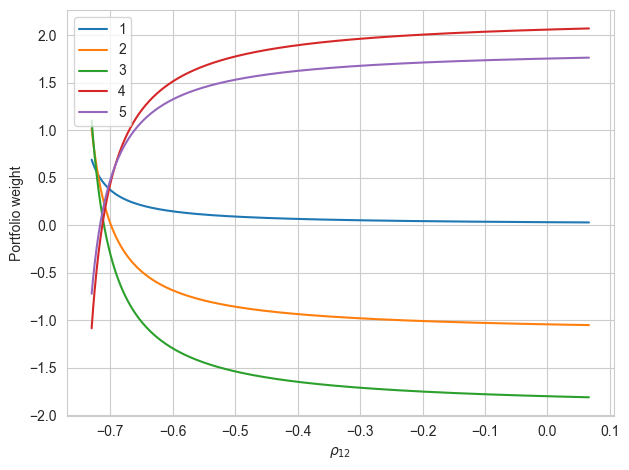

In [21]:
# Effect of one covariance: 
# hedging when cov is small enough, otherwise taking opposite positions; also signif. effect on other positions.
w_gmv_corr_effect = {}
for cov in numpy.linspace(1.1*Sigma[1, 0], -0.1*Sigma[1, 0], 1_000):
    cur_Sigma = Sigma.copy()
    cur_Sigma[1, 0] = cov
    cur_corr = cur_Sigma[1, 0] / numpy.sqrt(cur_Sigma[0, 0] * cur_Sigma[1, 1] )
    w_gmv_corr_effect[cur_corr] = global_minimum_variance_portfolio(Sigma=cur_Sigma).ravel()

w_gmv_corr_effect_df = pandas.DataFrame(w_gmv_corr_effect).T
w_gmv_corr_effect_df.columns = [*range(1, w_gmv_corr_effect_df.shape[1]+1)]

w_gmv_corr_effect_df.plot()
plt.xlabel('$\\rho_{12}$')
plt.ylabel('Portfolio weight')
plt.tight_layout();

### Optimization when sum of weights is equal to 1

We derive asset allocation -- this is nice. However, note that the sum of weights is arbitrary here. It makes sense to assume that they should some up to 1, right?

\begin{cases}
\begin{align*}
U(w) = w^{T}\mu - \dfrac{\gamma}{2} w^{T} \Sigma w \to max_{w} \\
w^{T}\tau = 1, \text{where } \tau \text{ is a vector of ones} \\
\end{align*}
\end{cases}

The method of Lagrange multipliers!<br>
$\Lambda = w^{T}\mu - \dfrac{\gamma}{2} w^{T}\Sigma w + \lambda(w^{T}\tau - 1) \to \max_{w, \lambda}$

FOC:
\begin{cases}
\begin{align*}
\frac{d\Lambda}{dh} = \mu -\gamma \Sigma w + \lambda \tau = 0 \\
\frac{d\Lambda}{d\lambda} = \mathbf{h}^{T} \tau - 1 = 0 \\
\end{align*}
\end{cases}

$\frac{d\Lambda}{dw} = 0$: $w = \dfrac{1}{\gamma}\Sigma^{-1}[\mu + \lambda \tau]$<br>
Here we already see an interesting result: our optimal allocation will be equal to the unconstrained optimum plus $\dfrac{\lambda}{\gamma}\Sigma^{-1}\tau$! <br>
Plugging $w$ in $\frac{d\Lambda}{d\lambda} = 0$, we get:<br><br>
$\dfrac{1}{\gamma}[\mu + \lambda \tau]^T\Sigma^{-1} \tau = 1$<br><br>
$\dfrac{1}{\gamma}\mu^T \Sigma^{-1} \tau + \dfrac{\lambda}{\gamma} \tau^T \Sigma^{-1} \tau = 1$<br><br> 
Now, denote $A = \tau^T\Sigma^{-1}\tau$.<br><br> 
$\lambda = \dfrac{\gamma - B}{A}$<br><br>
Then:<br><br>
$w^* = \dfrac{1}{\gamma}\Sigma^{-1}[\mu + \dfrac{\gamma - B}{A}\tau]$<br><br>

We can decompose this solution in two ways:<br><br>
1. Unconstraint optimum plus add-on:<br><br> $w^* = \dfrac{1}{\gamma}\Sigma^{-1}\mu + \dfrac{\gamma - B}{\gamma} * \dfrac{1}{A} * \Sigma^{-1}\tau = w_{\text{UC}} + \dfrac{\gamma - B}{\gamma}w_{\text{GMV}}$<br><br>
As previously, if $\gamma = B$, $w^* = w_{\text{UC}}$!

2. A weighted average of two portfolios GMV and $B$ (unconstrained with $\gamma=B$) portfolios:<br><br> $w^* = \dfrac{B}{\gamma} \dfrac{1}{B} \Sigma^{-1} \mu + \dfrac{\gamma - B}{\gamma} \dfrac{1}{A} \Sigma^{-1} \tau = \dfrac{B}{\gamma} \mathbf{w}_B + \dfrac{\gamma - B}{\gamma} \mathbf{w}_{\text{GMV}} = \phi \mathbf{w}_{\text{GMV}} + (1-\phi) \mathbf{w}_B$<br><br>
 So the optimal portfolio is a linear combination of a GMV portfolio the portfolio B!

In [52]:
def constrained_optimal_allocation1(mu: numpy.array, Sigma: numpy.array, gamma: float) -> numpy.array:
    """Using add-on"""
    w_uc = uncostrained_optimal_allocation(mu=mu, Sigma=Sigma, gamma=gamma)

    unit = numpy.ones_like(mu)
    Sigma_inv = numpy.linalg.inv(Sigma)
    A = unit.T @ Sigma_inv @ unit
    B = unit.T @ Sigma_inv @ mu
    w_gmv = global_minimum_variance_portfolio(Sigma=Sigma)
    addon = (gamma - B) / gamma * w_gmv # ).reshape(-1, 1)
    # print(addon)
    print(w_uc.shape, addon.shape)
    return w_uc + addon

def constrained_optimal_allocation2(mu: numpy.array, Sigma: numpy.array, gamma: float) -> numpy.array:
    """Using GMV"""
    unit = numpy.ones_like(mu)
    Sigma_inv = numpy.linalg.inv(Sigma)
    
    B = unit.T @ Sigma_inv @ mu
    phi = (gamma - B) / gamma

    wb = 1 / B * Sigma_inv @ mu
    # wb = scaled_optimum(mu=mu, Sigma=Sigma)

    w_gmv = global_minimum_variance_portfolio(Sigma=Sigma)

    return phi*w_gmv + (1-phi)*w_gmv

In [53]:
# Check that two methods are equivalent indeed!
coa1 = constrained_optimal_allocation1(mu=mu, Sigma=Sigma, gamma=gamma)
coa2 = constrained_optimal_allocation2(mu=mu, Sigma=Sigma, gamma=gamma)
assert numpy.abs(coa1 - coa2).max() < 1e-6 # TODO

(10, 1) (10, 1)


AssertionError: 

### Optimization with transaction costs

Alright, so far we have been living in a dream word without any transaction costs. However, when choosing asset allocaiton in reality, we need to take them into account!<br>

A typical way to model transaction costs is through a function that depends on a cost matrix $C$ and a vector of weight changes $w - w_0$. It is important to understand that $w_0$ is asset allocaiton right before rebalancing!<br>

A simplistic assumption about this function can give us a neat closed form solution. Assum that the cost function is the following:<br>
$c = (w - w_0)^TC(w-w_0)$.<br>
The cost matrix $C$ usually is a diagonal matrix. If so, the function is just:<br>
$c = c_1(w_1 - w_1^{0})^2 + c_2(w_2 - w_2^{0})^2 + ...$<br>
That is, for every squared weight change you incur a cost $c_i$.<br><br>

An unconstrained problem looks as follows:<br>

$U(w) = w^T\mu -\dfrac{\gamma}{2}w^T\Sigma w - \dfrac{\kappa}{2}(w - w_0)^TC(w-w_0) \to max_{w}$
FOC gives us:<br><br>
$w_{QTC} = (\gamma \Sigma + \kappa C)^{-1} (\mu + \kappa C w_0)$<br><br>
Here the transaction costs adjust the solution without them. For more intuition, consider the following cases:<br><br>
1. $\kappa=0$. Obviously, the problem reduces to the problem without transaction costs and $w^* = (\gamma \Sigma)^{-1} \mu = \dfrac{1}{\gamma} \Sigma^{-1} \mu$<br><br>
2. Before rebalancing, all weights are 0: $w_0 = 0$. E.g. this is the first period of our trading activity. Then $w^* = (\gamma \Sigma + \kappa C)^{-1} \mu = \tilde{\Sigma}^{-1} \mu$. That is, transaction costs adjust only the covariance matrix.<br><br>
3. $C = \Sigma$: $w^* = \dfrac{1}{\gamma + \kappa}\Sigma^{-1}\mu + \dfrac{\kappa}{\gamma + \kappa}w_0$ (WHAT IS SO NICE ABOUT IT?)

In [54]:
def asset_allocation_with_cost_matrix(gamma, Sigma, kappa, Cost_matrix, mu, previous_weights):

    first_m = gamma * Sigma + kappa * Cost_matrix
    first_m_inv = numpy.linalg.inv(first_m)
    second_m = mu + kappa * Cost_matrix @ previous_weights

    return first_m_inv @ second_m

In [55]:
kappa = 5
Cost_matrix = numpy.diag(0.1 * numpy.ones_like(mu))
previous_weights = numpy.ones_like(mu) / len(mu) # equally-weighted portfolio

w_qtc = asset_allocation_with_cost_matrix(gamma, Sigma, kappa=kappa, Cost_matrix=Cost_matrix, mu=mu, previous_weights=previous_weights)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

In [56]:
w_qtc_experiments = {
    k: asset_allocation_with_cost_matrix(gamma, Sigma, kappa=k, Cost_matrix=Cost_matrix, mu=mu, previous_weights=previous_weights)
    for k in numpy.linspace(0.0, 10.0, 100)
}
w_qtc_experiments_df = pandas.DataFrame.from_dict(w_qtc_experiments, orient='index')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

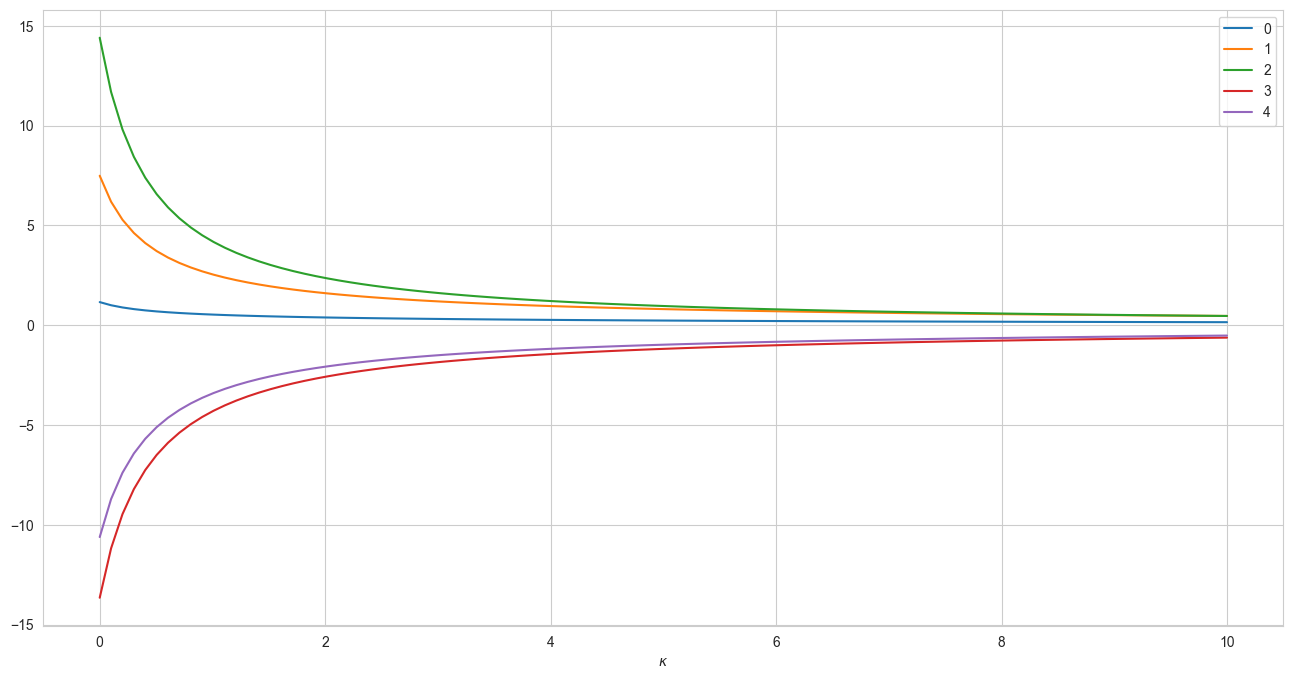

In [57]:
w_qtc_experiments_df.plot(figsize=(16, 8))
plt.xlabel('$\kappa$')
plt.show();

In [58]:
def asset_allocation_with_cost_matrix_zero_weight_sum(gamma, Sigma, kappa, Cost_matrix, mu, previous_weights, weight_sum: float = 0):

    F = numpy.linalg.inv(gamma*Sigma + kappa*Cost_matrix)
    g = (mu + kappa*Cost_matrix@previous_weights).reshape(-1, 1) # .reshape(-1, 1)
    unit = numpy.ones_like(g).reshape(-1, 1)

    lambda_ = 1 / (unit.T @ F.T @ unit) * (weight_sum - g.T @ F.T @ unit)

    w = F@g + lambda_*F@unit

    return w

In [59]:
trans_cost_portfilio = asset_allocation_with_cost_matrix_zero_weight_sum(gamma=gamma, Sigma=Sigma, kappa=kappa, Cost_matrix=Cost_matrix, mu=mu, previous_weights=previous_weights)
trans_cost_portfilio.sum()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

In [60]:
trans_cost_portfilio = asset_allocation_with_cost_matrix_zero_weight_sum(gamma=gamma, Sigma=Sigma, kappa=kappa, Cost_matrix=Cost_matrix, mu=mu, previous_weights=previous_weights, weight_sum=1)
trans_cost_portfilio.sum()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

In [61]:
import numpy

def quadratic_cost_function(weight_change, cost_per_unit):
    return cost_per_unit * weight_change**2

def linear_cost_function(weight_change, cost_per_unit):
    return cost_per_unit *numpy.abs(weight_change)

In [62]:
# Transaction costs + sum of weights = 1

def asset_allocation_with_transaction_consts_and_constraints():

    S = numpy.linalg.inv(gamma * Sigma + kappa * Cost_matrix)

    multiplier = 1 / numpy.ones()
    lambda_ = 

SyntaxError: invalid syntax (1253749544.py, line 8)

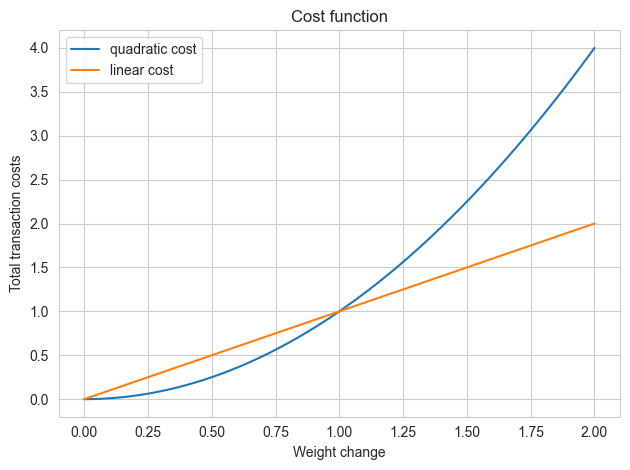

In [63]:
import matplotlib.pyplot as plt
import pandas

weight_change = numpy.linspace(0, 2, 10_000)
total_quadratic_cost = quadratic_cost_function(weight_change, cost_per_unit=1)
total_linear_cost = linear_cost_function(weight_change, cost_per_unit=1)

# costs = pandas.DataFrame

plt.plot(weight_change, total_quadratic_cost, label='quadratic cost')
plt.plot(weight_change, total_linear_cost, label='linear cost')
plt.xlabel('Weight change')
plt.ylabel('Total transaction costs')
plt.title('Cost function')
plt.legend()
plt.tight_layout();

However, sometimes ppl assume linear cost function:<br><br>

$U(w) = w^T\mu -\dfrac{\gamma}{2}w^T\Sigma w - \dfrac{\kappa}{2}c^T|w-w_0| \to max_{w}$<br><br>

This function is not continuous and thus does not have a closed form solution. We can find a solution numerically though!

### Using cvxpy
https://www.cvxpy.org/version/1.1/examples/index.html

In [64]:
import cvxpy as cp
import numpy

numpy.random.seed(1)
n = 10
mu = numpy.abs(numpy.random.randn(n, 1))
Sigma = numpy.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [65]:
w = cp.Variable(n)
gamma_cp = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma) # w.T @ Sigma @ w
prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1])

gamma_cp.value = 1
prob.solve()

print(f'Status: {prob.solution.status}')
print(f'Optimal allocation:', w.value)

Status: optimal
Optimal allocation: [ 0.043562   -0.11544821  0.20750816  0.16503849  0.10026211  0.27292388
  0.1048602  -0.03309569  0.12886495  0.1255241 ]


In [66]:
constrained_optimal_allocation1(mu=mu, Sigma=Sigma, gamma=gamma)

(10, 1) (10, 1)


array([[-0.0782122 ],
       [-0.17593496],
       [ 0.01079487],
       [ 0.30188013],
       [ 0.28581828],
       [ 0.4687055 ],
       [ 0.13533128],
       [-0.14675597],
       [ 0.14867016],
       [ 0.04970291]])

In [67]:
constrained_optimal_allocation2(mu=mu, Sigma=Sigma, gamma=gamma)

array([[ 0.16533621],
       [-0.05496146],
       [ 0.40422146],
       [ 0.02819686],
       [-0.08529405],
       [ 0.07714226],
       [ 0.07438911],
       [ 0.08056459],
       [ 0.10905974],
       [ 0.20134529]])

In [68]:
gamma = 1
unit = numpy.ones_like(mu)
Sigma_inv = numpy.linalg.inv(Sigma)

A = unit.T @ Sigma_inv @ unit
B = unit.T @ Sigma_inv @ mu

wa = 1/A * Sigma_inv @ unit
wb = 1/B * Sigma_inv @ mu

w_opt = B/gamma * wb + (gamma-B)/gamma * wa

w_opt

array([[-0.32176061],
       [-0.29690846],
       [-0.38263171],
       [ 0.5755634 ],
       [ 0.65693062],
       [ 0.86026874],
       [ 0.19627345],
       [-0.37407653],
       [ 0.18828058],
       [-0.10193948]])

In [ ]:
import pandas
comparison_df = pandas.DataFrame(
    {'cvxpy': w.value.ravel(), 'CFS': w_opt.ravel()}
)
comparison_df

,cvxpy,CFS
0,-0.078212,-0.321761
1,-0.175935,-0.296908
2,0.010795,-0.382632
3,0.301880,0.575563
4,0.285818,0.656931
5,0.468705,0.860269
6,0.135331,0.196273
7,-0.146756,-0.374077
8,0.148670,0.188281
9,0.049703,-0.101939


In [ ]:
comparison_df.sum()

cvxpy    1.0
CFS      1.0
dtype: float64

#### Long only portfolio optimization

In [ ]:
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma) # w.T @ Sigma @ w
prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0])

gamma.value = 1
prob.solve()

print(f'Status: {prob.solution.status}')
print(f'Optimal allocation:', w.value)

Status: optimal
Optimal allocation: [ 7.21944027e-02 -9.76385333e-24  4.42551378e-02  2.13447615e-01
  1.84913540e-01  2.94178083e-01  4.46087459e-02 -1.73168005e-23
  8.47886626e-02  6.16138131e-02]


In [ ]:
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma) # w.T @ Sigma @ w

########################
kappa = cp.Parameter(nonneg=True)
c = 0.1 * numpy.ones(n)
w0 = numpy.ones(n) / n
cost = c.T @ cp.abs(w - w0)
########################

prob = cp.Problem(cp.Maximize(ret - gamma * risk - kappa * cost), [cp.sum(w) == 1])

gamma.value = 1
kappa.value = 0.5
prob.solve()

print(f'Status: {prob.solution.status}')
print(f'Optimal allocation:', w.value)

Status: optimal
Optimal allocation: [-0.04096586 -0.1705072   0.1         0.23755978  0.21391199  0.41460558
  0.13909955 -0.09096296  0.1197822   0.0774769 ]


Other questions to touch:
1. Where to take mu from?
2. Where to take Sigma from?
3. Other more involved constraints